In [1]:
from os import path
import os
import glob
import warnings

import astropy.coordinates as coord
from astropy.table import Table, hstack, join
import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
import reproject

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from scipy.spatial import cKDTree

from pyia import GaiaData
import gala.coordinates as gc
from dustmaps.sfd import SFDQuery
from astroquery.gaia import Gaia

from sfd import reddening

login_file = path.expanduser('~/.gaia/archive.login')
if path.exists(login_file):
    with open(login_file) as f:
        username = f.readline()
        password = f.readline()
    print('Logging in with user: {0}'.format(username))
    Gaia.login(user=username, password=password)

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Logging in with user: apricewh



In [2]:
data_path = '../data/xmatch/'
if not path.exists(data_path):
    os.makedirs(data_path)

Width and height of polygon to select:

In [3]:
w = 12*u.deg
h = 8*u.deg

Corners of spherical polygonal to select:

In [4]:
cluster_c = coord.SkyCoord(ra=179*u.deg, dec=-29*u.deg)
cl_mag = cluster_c.transform_to(gc.MagellanicStream)

l1, l2 = cl_mag.L - w/2, cl_mag.L + w/2
b1, b2 = cl_mag.B - h/2, cl_mag.B + h/2
corners_c = gc.MagellanicStream(L=u.Quantity([l1, l1, l2, l2]),
                                B=u.Quantity([b1, b2, b2, b1])).transform_to(coord.ICRS)
corners_c = coord.SkyCoord(corners_c)
corners_c

<SkyCoord (ICRS): (ra, dec) in deg
    [( 182.195491  , -35.51467868), ( 172.72408967, -33.70157734),
     ( 176.37457425, -22.27711849), ( 184.81885184, -24.2360228 )]>

In [5]:
where_clause = '''(parallax < 0.5 OR parallax IS NULL) AND 
    CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
             POLYGON('ICRS', 
                     {0[0].ra.degree}, {0[0].dec.degree},
                     {0[1].ra.degree}, {0[1].dec.degree},
                     {0[2].ra.degree}, {0[2].dec.degree},
                     {0[3].ra.degree}, {0[3].dec.degree})) = 1 AND
    (pmra > -10) AND (pmra < 10) AND 
    (pmdec > -10) AND (pmdec < 10)
'''.format(corners_c)

## First look at Isochrones to help color selection

In [6]:
dup_cols = ['EEP', 'isochrone_age_yr',
'initial_mass',
'star_mass',
'log_Teff',
'log_g',
'log_L',
'[Fe/H]_init',
'[Fe/H]',
'phase']

In [7]:
# alltbl = None
# for fn in glob.glob('../data/old/-0.5/MIST*'):
#     tbl = Table.read(fn, header_start=12, format='ascii')
#     if alltbl is None:
#         alltbl = tbl
#     else:
#         for col in dup_cols:
#             tbl.remove_column(col)
#         alltbl = hstack((alltbl, tbl))
# alltbl.write('../data/FeH-0.5_all.fits', overwrite=True)

In [8]:
iso = Table.read('../data/FeH-1_all.fits')
DM = coord.Distance(30*u.kpc).distmod.value

## Gaia DR2 alone:

(21, 10)

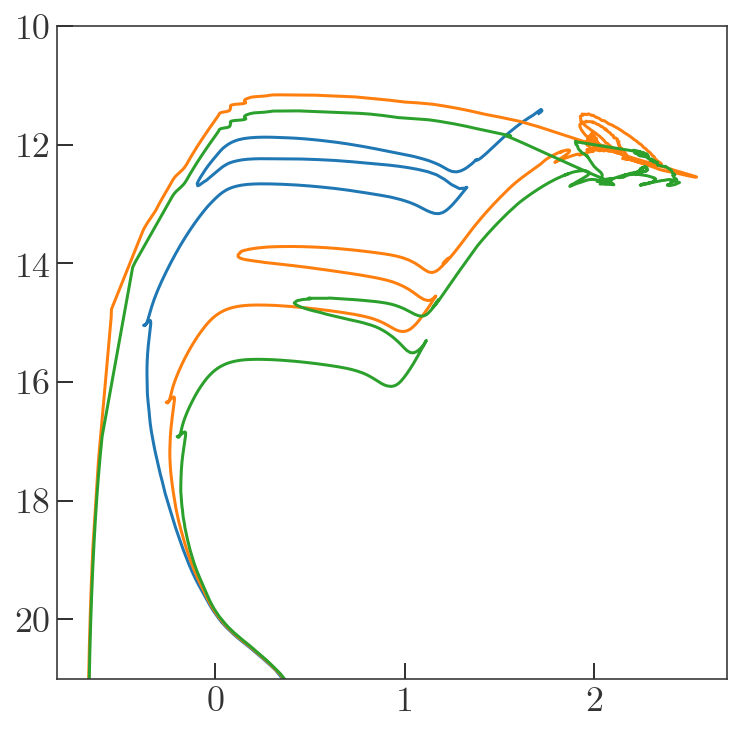

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for age in np.unique(iso['isochrone_age_yr'])[::2]:
    i = iso[iso['isochrone_age_yr'] == age]
    ax.plot(i['Gaia_BP_DR2Rev']-i['Gaia_RP_DR2Rev'],
            i['Gaia_G_DR2Rev'] + DM, marker='')

ax.set_ylim(21, 10)

In [10]:
q_fmt ='''SELECT *
FROM gaiadr2.gaia_source AS gaia
WHERE {0} 
'''
q = q_fmt.format(where_clause)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    job = Gaia.launch_job_async(q, name='LA-gaia')

Launched query: 'SELECT *
FROM gaiadr2.gaia_source AS gaia
WHERE (parallax < 0.5 OR parallax IS NULL) AND 
    CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
             POLYGON('ICRS', 
                     182.1954909980203, -35.51467868323814,
                     172.7240896740689, -33.70157733692543,
                     176.3745742549848, -22.277118488646703,
                     184.81885184435987, -24.236022801996057)) = 1 AND
    (pmra > -10) AND (pmra < 10) AND 
    (pmdec > -10) AND (pmdec < 10)
 
'
Retrieving async. results...
Query finished.


In [11]:
tbl = job.get_results()

for c in tbl.colnames:
    if tbl[c].dtype == object:
        tbl[c] = np.array(tbl[c]).astype(str)
tbl.write(path.join(data_path, 'gaiadr2.fits'), overwrite=True)

(21.5, 8)

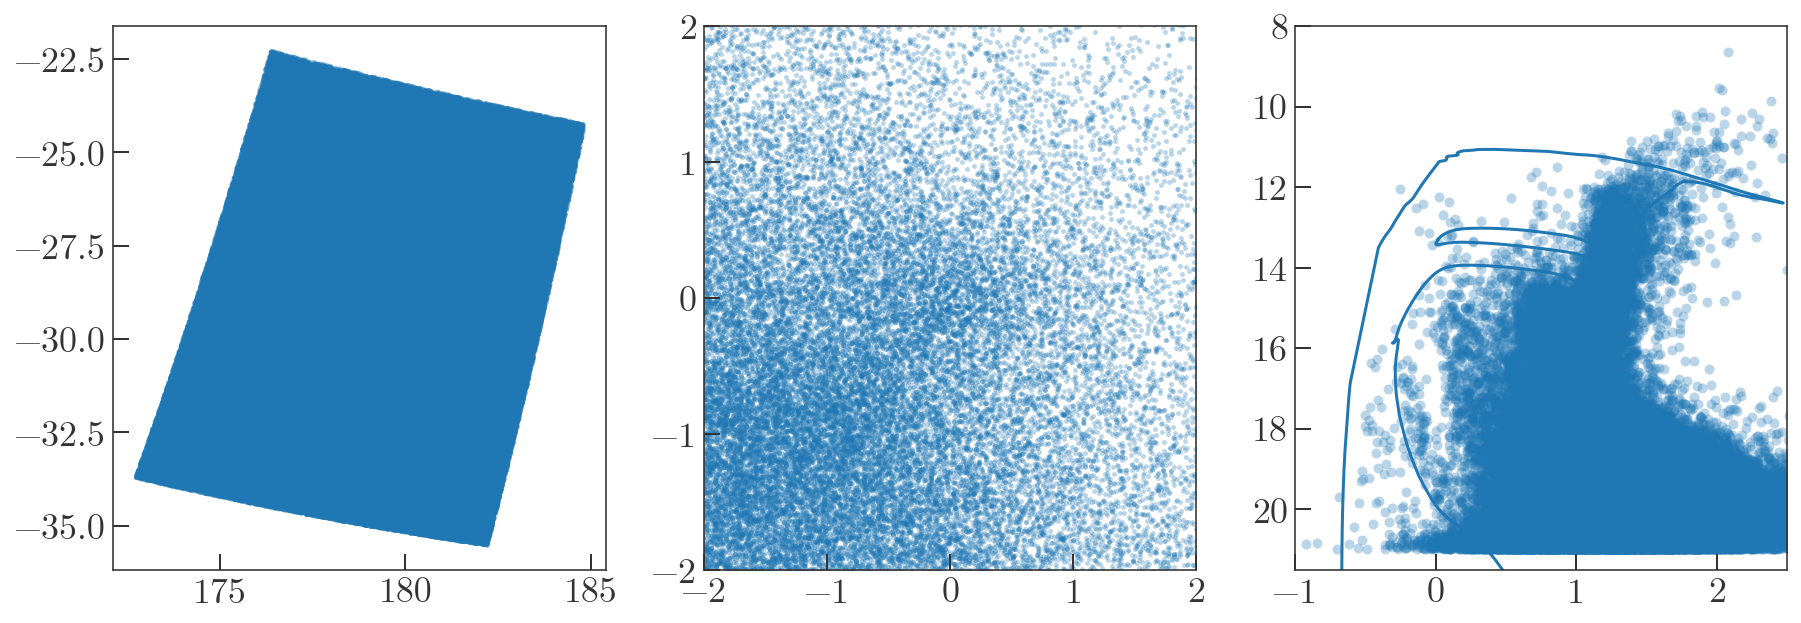

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes[0]
ax.scatter(tbl['ra'], tbl['dec'], alpha=0.3, s=6, linewidth=0)

ax = axes[1]
ax.scatter(tbl['pmra'], tbl['pmdec'], alpha=0.3, s=6, linewidth=0)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

ax = axes[2]
ax.scatter(tbl['phot_bp_mean_mag']-tbl['phot_rp_mean_mag'], 
           tbl['phot_g_mean_mag'], alpha=0.3, linewidth=0)

i = iso[np.isclose(iso['isochrone_age_yr'], 1e8)]
ax.plot(i['Gaia_BP_DR2Rev']-i['Gaia_RP_DR2Rev'],
        i['Gaia_G_DR2Rev'] + DM, marker='')
    
ax.set_xlim(-1, 2.5)
ax.set_ylim(21.5, 8)

## Pan-STARRS:

In [13]:
q_fmt ='''SELECT gaia.source_id, ps1.*
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.panstarrs1_best_neighbour AS xmatch
    ON gaia.source_id = xmatch.source_id
INNER JOIN gaiadr2.panstarrs1_original_valid AS ps1
    ON ps1.obj_id = xmatch.original_ext_source_id
WHERE {0}
'''
q = q_fmt.format(where_clause)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    job = Gaia.launch_job_async(q, name='LA-ps1')

Launched query: 'SELECT gaia.source_id, ps1.*
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.panstarrs1_best_neighbour AS xmatch
    ON gaia.source_id = xmatch.source_id
INNER JOIN gaiadr2.panstarrs1_original_valid AS ps1
    ON ps1.obj_id = xmatch.original_ext_source_id
WHERE (parallax < 0.5 OR parallax IS NULL) AND 
    CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
             POLYGON('ICRS', 
                     182.1954909980203, -35.51467868323814,
                     172.7240896740689, -33.70157733692543,
                     176.3745742549848, -22.277118488646703,
                     184.81885184435987, -24.236022801996057)) = 1 AND
    (pmra > -10) AND (pmra < 10) AND 
    (pmdec > -10) AND (pmdec < 10)

'
Retrieving async. results...
Query finished.


In [14]:
tbl = job.get_results()

for c in tbl.colnames:
    if tbl[c].dtype == object:
        tbl[c] = np.array(tbl[c]).astype(str)
tbl.write(path.join(data_path, 'gaia-ps1.fits'), overwrite=True)

(22, 8)

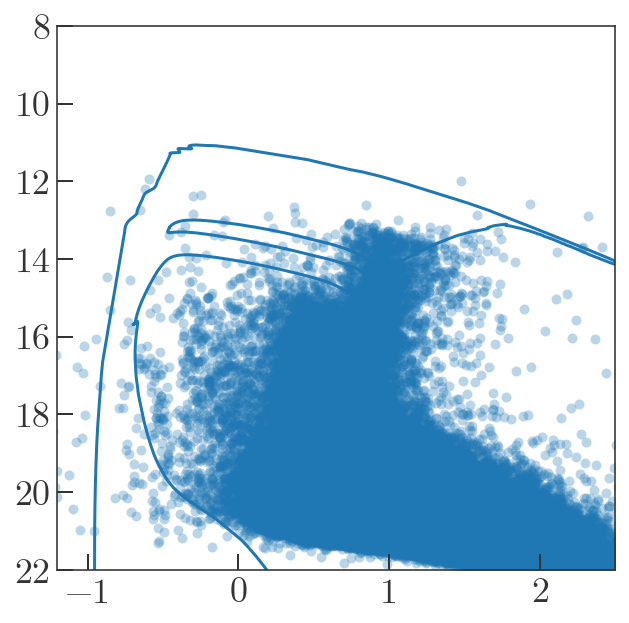

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(tbl['g_mean_psf_mag']-tbl['i_mean_psf_mag'], 
           tbl['g_mean_psf_mag'], alpha=0.3, linewidth=0)

i = iso[np.isclose(iso['isochrone_age_yr'], 1e8)]
ax.plot(i['PS_g']-i['PS_i'],
        i['PS_g'] + DM, marker='')
    
ax.set_xlim(-1.2, 2.5)
ax.set_ylim(22, 8)

## Allwise:

In [16]:
q_fmt ='''SELECT gaia.source_id, wise.*
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.allwise_best_neighbour AS xmatch
    ON gaia.source_id = xmatch.source_id
INNER JOIN gaiadr1.allwise_original_valid AS wise
    ON wise.allwise_oid = xmatch.allwise_oid
WHERE {0}
'''
q = q_fmt.format(where_clause)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    job = Gaia.launch_job_async(q, name='LA-wise')

Launched query: 'SELECT gaia.source_id, wise.*
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.allwise_best_neighbour AS xmatch
    ON gaia.source_id = xmatch.source_id
INNER JOIN gaiadr1.allwise_original_valid AS wise
    ON wise.allwise_oid = xmatch.allwise_oid
WHERE (parallax < 0.5 OR parallax IS NULL) AND 
    CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
             POLYGON('ICRS', 
                     182.1954909980203, -35.51467868323814,
                     172.7240896740689, -33.70157733692543,
                     176.3745742549848, -22.277118488646703,
                     184.81885184435987, -24.236022801996057)) = 1 AND
    (pmra > -10) AND (pmra < 10) AND 
    (pmdec > -10) AND (pmdec < 10)

'
Retrieving async. results...
Query finished.


In [17]:
tbl = job.get_results()

for c in tbl.colnames:
    if tbl[c].dtype == object:
        tbl[c] = np.array(tbl[c]).astype(str)
        
    tbl[c].unit = None
    
    tbl[c] = np.array(tbl[c])
tbl.meta = dict()

tbl.write(path.join(data_path, 'gaia-allwise.fits'), overwrite=True)

## 2MASS:

In [18]:
q_fmt ='''SELECT gaia.source_id, tmass.*
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.tmass_best_neighbour AS xmatch
    ON gaia.source_id = xmatch.source_id
INNER JOIN gaiadr1.tmass_original_valid AS tmass
    ON tmass.tmass_oid = xmatch.tmass_oid
WHERE {0}
'''
q = q_fmt.format(where_clause)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    job = Gaia.launch_job_async(q, name='LA-2mass')

Launched query: 'SELECT gaia.source_id, tmass.*
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.tmass_best_neighbour AS xmatch
    ON gaia.source_id = xmatch.source_id
INNER JOIN gaiadr1.tmass_original_valid AS tmass
    ON tmass.tmass_oid = xmatch.tmass_oid
WHERE (parallax < 0.5 OR parallax IS NULL) AND 
    CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
             POLYGON('ICRS', 
                     182.1954909980203, -35.51467868323814,
                     172.7240896740689, -33.70157733692543,
                     176.3745742549848, -22.277118488646703,
                     184.81885184435987, -24.236022801996057)) = 1 AND
    (pmra > -10) AND (pmra < 10) AND 
    (pmdec > -10) AND (pmdec < 10)

'
Retrieving async. results...
Query finished.


In [19]:
tbl = job.get_results()

for c in tbl.colnames:
    if tbl[c].dtype == object:
        tbl[c] = np.array(tbl[c]).astype(str)
        
    tbl[c].unit = None
    
    tbl[c] = np.array(tbl[c])
tbl.meta = dict()

tbl.write(path.join(data_path, 'gaia-2mass.fits'), overwrite=True)

## Galex:

Manually downloaded 8 deg radius around (179, -29) here: http://vizier.u-strasbg.fr/viz-bin/VizieR-3

Crossmatch with Gaia, manually

In [20]:
gaia = Table.read(path.join(data_path, 'gaiadr2.fits'))

In [21]:
galex = Table.read(path.join(data_path, 'galex.fits'))

In [22]:
gaia_c = coord.SkyCoord(ra=gaia['ra'], dec=gaia['dec'])
galex_c = coord.SkyCoord(ra=galex['RAJ2000'], dec=galex['DEJ2000'])

In [23]:
idx, sep, _ = galex_c.match_to_catalog_sky(gaia_c)

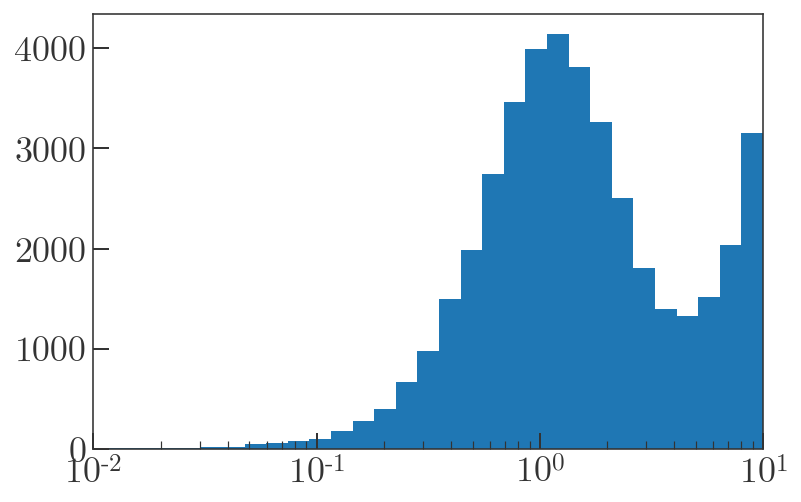

In [24]:
plt.hist(sep.arcsecond, bins=np.logspace(-2, 1, 32));
plt.xlim(1e-2, 10)
plt.xscale('log')

In [25]:
galex_xmatch = galex[sep < 4*u.arcsec].copy()
galex_xmatch['source_id'] = gaia[idx[sep < 4*u.arcsec]]['source_id']

In [27]:
galex_xmatch.write(path.join(data_path, 'gaia-galex.fits'), overwrite=True)

---

## Join All The Things!

In [28]:
len(gaia)

297303

In [29]:
all_tbl = gaia.copy()
for fn in glob.glob(path.join(data_path, 'gaia-*.fits')):
    tbl_name = path.splitext(path.basename(fn))[0].split('-')[1]
    tbl = Table.read(fn)
    print(path.basename(fn), len(tbl))

    for c in tbl.colnames:
        if c == 'source_id': 
            continue

        tbl.rename_column(c, '{0}_{1}'.format(tbl_name, c))
        
    all_tbl = join(all_tbl, tbl, keys='source_id', join_type='left')

gaia-galex.fits 33301
gaia-allwise.fits 154671
gaia-ps1.fits 176054
gaia-2mass.fits 80103


In [30]:
for c in all_tbl.colnames:
    all_tbl[c] = np.array(all_tbl[c])

In [31]:
all_tbl.write('../data/data-joined.fits', overwrite=True)

In [32]:
len(all_tbl)

297482